# LTU-ILI: Append dummy data test

### Author:
  - [@CompiledAtBirth](https://github.com/CompiledAtBirth) (Nicolas Chartier)


## Summary

- This notebook aims at providing tests related to the issue [Issue34_ltu-ili](https://github.com/maho3/ltu-ili/issues/34), and in the next step should be integrated into a working example from the [@ltu-ili](https://github.com/maho3/ltu-ili) framework of the [Simons Collaboration on Learning the Universe](https://www.learning-the-universe.org).
- Topics: Parameter inference with Density Estimation, standard summary statistics from cosmological N-body simulations.
- Goal: Assess the capabilities of learning posterior distributions when the data vector has higher dimension. We consider two cases 1) When noise independent of the parameters to infer is present 2) When the data vector has much higher dimension and supposedly carries more information about the parameters.

## Tools and data

- The main tool is the simulation-based inference package [sbi](https://www.mackelab.org/sbi/).
- Basic knowledge about [PyTorch](https://pytorch.org/) is useful.
- We use some common packages: [ChainConsumer](https://samreay.github.io/ChainConsumer/), [Pandas](https://pandas.pydata.org/) and [netCDF4](https://unidata.github.io/netcdf4-python/).
- TARP validation metric from [Lemos et al, 2023](https://arxiv.org/abs/2302.03026)
- The data is from the publicly available [Quijote Simulations](https://quijote-simulations.readthedocs.io/en/latest/). Unless stated otherwise, all clustering statistics used here stem from the Latin Hypercube set with massless neutrinos.

## Literature and references (non-exhaustive)
- More details about the Quijote simulations in this [publication](https://arxiv.org/abs/1909.05273).
- Density estimation: publications related to Masked Autoregressive Flows [(MAF)](https://arxiv.org/abs/1705.07057) and Masked Autoencoder for Distribution Estimation [(MADE)](https://arxiv.org/abs/1502.03509). We build a model of the former by stacking instances of the latter.
- Sequential Neural Posterior Estimation (SNPE): [NeurIPS2016](https://proceedings.neurips.cc/paper_files/paper/2016/file/6aca97005c68f1206823815f66102863-Paper.pdf) for SNPE-A, [NeurIPS2017](https://proceedings.neurips.cc/paper_files/paper/2017/file/addfa9b7e234254d26e9c7f2af1005cb-Paper.pdf) for SNPE-B, [ICML2019](http://proceedings.mlr.press/v97/greenberg19a/greenberg19a.pdf) for SNPE-C and [NeurIPS2022](https://arxiv.org/pdf/2210.04815.pdf).
- Sequential Neural Likelihood Estimation (SNLE): Not used in this notebook, but for reference e.g. [AISTATS2019](http://proceedings.mlr.press/v89/papamakarios19a/papamakarios19a.pdf).
- General useful [review](https://arxiv.org/abs/1911.01429) about Simulation-Based Inference (SBI), also called Implicit-Likelihood Inference (ILI).

In [ ]:
!pip install --upgrade --quiet tarp sbi chainconsumer netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import copy
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

# see Interface Usage examples at eg. https://www.mackelab.org/sbi/tutorial/02_flexible_interface/
import torch
from sbi import utils as utils
from sbi.inference import SNPE, SNLE_A, SNLE, likelihood_estimator_based_potential, MCMCPosterior

import tarp

from chainconsumer import ChainConsumer

In [ ]:
help(tarp.get_drp_coverage)

Help on function get_drp_coverage in module tarp.drp:

get_drp_coverage(samples: numpy.ndarray, theta: numpy.ndarray, references: Union[str, numpy.ndarray] = 'random', metric: str = 'euclidean') -> Tuple[numpy.ndarray, numpy.ndarray]
    Estimates coverage with the distance to random point method.
    
    Reference: `Lemos, Coogan et al 2023 <https://arxiv.org/abs/2302.03026>`_
    
    Args:
        samples: the samples to compute the coverage of, with shape ``(n_samples, n_sims, n_dims)``.
        theta: the true parameter values for each samples, with shape ``(n_sims, n_dims)``.
        references: the reference points to use for the DRP regions, with shape
            ``(n_references, n_sims)``, or the string ``"random"``. If the later, then
            the reference points are chosen randomly from the unit hypercube over
            the parameter space.
        metric: the metric to use when computing the distance. Can be ``"euclidean"`` or
            ``"manhattan"``.
    
    R

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
help(drive)

# Other possibility: uppload files with GUI from computer
#from google.colab import files
#files.upload()

Help on module google.colab.drive in google.colab:

NAME
    google.colab.drive - Colab-specific Google Drive integration.

FUNCTIONS
    flush_and_unmount(timeout_ms=86400000)
        Unmount Google Drive and flush any outstanding writes to it.
    
    mount(mountpoint, force_remount=False, timeout_ms=120000, readonly=False)
        Mount your Google Drive at the specified mountpoint path.

DATA
    __all__ = ['flush_and_unmount', 'mount']

FILE
    /usr/local/lib/python3.10/dist-packages/google/colab/drive.py




In [ ]:
# This will prompt for authorization.
#drive.mount('/content/drive/MyDrive/ColabNotebooks/Data/') # mounting a specific subfolder does not work
drive.mount('/content/drive', force_remount = True)

# files will be present in "/content/drive/My Drive".
dataDir =  "/content/drive/MyDrive/ColabNotebooks/LTU_ILI/Data/quijote_z0p5"
!ls $dataDir

Mounted at /content/drive
Bk  latin_hypercube_params.txt	Pk


In [ ]:
# Setting pyTorch device as GPU if available, else CPU
deviceStr = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(deviceStr)
print('Using device:', device)

Using device: cuda


In [ ]:
# Sanity check sbi (from documentation), optional cell
from sbi.examples.minimal import simple
posterior = simple()
print(posterior)
del posterior

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 83 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [ ]:
print(type(SNPE()))

<class 'sbi.inference.snpe.snpe_c.SNPE_C'>


# 0) Preliminary: load and understand the power spectrum LH data

### Simulations and cosmology

In [ ]:
# Cosmological parameters, fiducial values for prior
paramStr=[r"$\Omega_m$", r"$\Omega_b$",r"$h$",r"$n_s$",r"$\sigma_8$"]

# Means are Quijote fiducial parameters, and for the standard deviations I checked some literature
Om0 = 0.3175 ; s_Om0 = 0.0074
Ob0 = 0.049 ; s_Ob0 = 0.0003
h = 0.6711 ; s_h = 0.0054
n_s = 0.9424 ; s_ns = 0.0042
sigma_8 = 0.834 ; s_sigma_8 = 0.006
#w = -1.0 ; s_w = 0.05

fiducial = np.array([Om0, Ob0, h, n_s, sigma_8])
factVariance = 1.0 # if we want to make Planck-like uncertaintes wider or thiner for Gaussian priors

# Arbitrary constraints parametrized with standard deviations for the test, should be more realistic given the cosmology literature
constraints = factVariance * np.array([s_Om0**2,s_Ob0**2,s_h**2,s_ns**2,s_sigma_8**2])
theta = np.float32(np.loadtxt(dataDir + "/latin_hypercube_params.txt", delimiter = " ", skiprows = 1))

## !!!!!!!!!
# For SNPE, we must distinguish the proposal prior with which the simulations were run to the prior in the Bayesian Inference
# Below are Quijote latin hypercube bounds
lowProp = np.array([0.1, 0.03, 0.5, 0.8, 0.6])
upProp = np.array([0.5, 0.07, 0.9, 1.2, 1.0])

# axis along which RSD has been computed (careful about confusions)
axRSD = 0

# Data Files
filePk = "PK_z0p5_RSD%i_kmax1p0.nc"%axRSD
fileBkIso = "LH_Bk_RSD%i_iso.h5"%axRSD # iso for isosceles triangles only
fileBkEqui = "LH_Bk_RSD%i_equi.h5"%axRSD # equi for equilqteral triangles only
#k3D = np.float32(np.loadtxt(dataDir + "/../k3D_quijote.txt"))


From the Quijote Paper, we read in section 2.6:
"[...] we use a latin-hypercube where
we vary the value of Ωm between 0.1 and 0.5, Ωb be-
tween 0.03 and 0.07, h between 0.5 and 0.9, ns between
0.8 and 1.2, σ8 between 0.6 and 1.0 and keep fixed Mν
to 0.0 eV and w to -1"

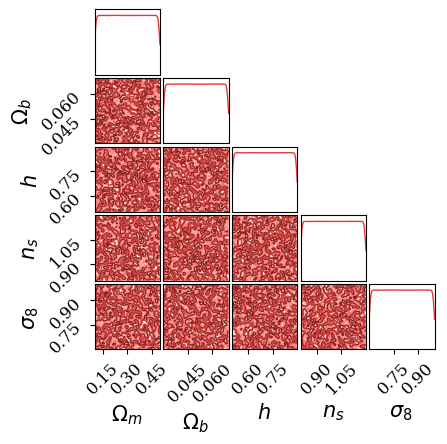

In [ ]:
# In the LH, the marginal 1D contours should be close to uniform over the chosen ranges
cpre = ChainConsumer()
cpre.add_chain(theta, parameters = paramStr, name = "Cosmo LH", zorder = 1, color = "red")

cpre.configure(usetex = False,serif = True, shade=False, cloud = True, bar_shade=False,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 20},
            legend_color_text=True)
figpre = cpre.plotter.plot(figsize  =(4,4))

### Load the data

In [ ]:
# Explore .nc format as training
pkData = nc.Dataset(dataDir  + "/Pk/" + filePk)

# Individual dimensions are accessed via dat1.dimensions['x']
for group in pkData.groups.values():
    print(group)

<class 'netCDF4._netCDF4.Group'>
group /LH_z0p5:
    dimensions(sizes): Seed(2000), multipole(3), k3D(158)
    variables(dimensions): float64 k3D(k3D), int64 multipole(multipole), int64 Seed(Seed), float64 PkRSD_ax0(Seed, multipole, k3D)
    groups: 
<class 'netCDF4._netCDF4.Group'>
group /fiducial_z0p5:
    dimensions(sizes): Seed(500), multipole(3), k3D(158)
    variables(dimensions): float64 k3D(k3D), int64 multipole(multipole), int64 Seed(Seed), float64 PkRSD_ax0(Seed, multipole, k3D)
    groups: 


In [ ]:
# Just playing for netCDF4 related examples
pkLH = pkData["LH_z0p5"]
pkFid = pkData["fiducial_z0p5"]

# if we just just use Dataset.dimensions, just the names are shown without details
for dim in pkLH.dimensions.values():
  print(dim)

k3D = pkLH["k3D"]
ells = pkLH["multipole"]
seedsLH = pkLH["Seed"]
seedsFid = pkFid["Seed"]
print(pkLH["PkRSD_ax%i"%axRSD].shape)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Seed', size = 2000
<class 'netCDF4._netCDF4.Dimension'>: name = 'multipole', size = 3
<class 'netCDF4._netCDF4.Dimension'>: name = 'k3D', size = 158
(2000, 3, 158)


In [ ]:
# Retrieve LH dataset as an array
pkLH_ell = pkLH["PkRSD_ax%i"%axRSD][:,ells==axRSD,:]
print(pkLH_ell.shape)

# Idem for fiducial dataset, which we will use to compute fake observed data and evaluate a trained posterior distribution
pkFid_ell = pkFid["PkRSD_ax%i"%axRSD][:,ells==axRSD,:]
pk0 = torch.from_numpy(np.mean(pkFid_ell, axis = 0)).to(dtype = torch.float32, device = deviceStr) # better than torch.Tensor for dtypes
pk0.get_device() # should return 0 for a GPU tensor because the function returns -1 for cpu tensiors

(2000, 158)


0

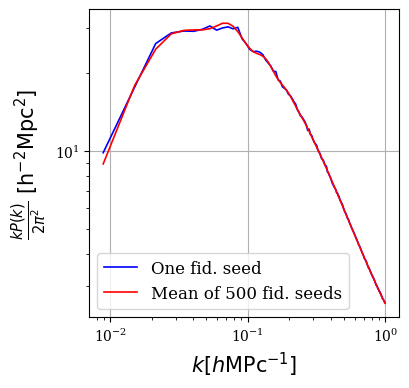

In [ ]:
# Plot Pk monopole example and the fiducial mean for illustration
seedExample = 28
pkTest = pkFid_ell[seedExample,:]

plt.figure(figsize=(4,4))
plt.loglog(k3D[:], k3D[:]/(2*np.pi**2)*pkTest, linewidth=1.2, color = "blue", label = "One fid. seed")
plt.loglog(k3D[:],  k3D[:]/(2*np.pi**2)*pk0.cpu().numpy(), linewidth=1.2, color = "red", label = "Mean of %i fid. seeds"%pkFid_ell.shape[0])
plt.xlabel(r'$k [h \rm{MPc}^{-1}]$',fontsize=15)
plt.ylabel(r"$\frac{kP(k)}{2\pi^2}$ $[{\rm h^{-2} Mpc^{2}}]$",fontsize = 15)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 12, loc = "best")
plt.grid()

### Train and test data
To compute the TARP metric (https://arxiv.org/abs/2302.03026), we actually need a subset of the simulations playing the role of test data.

In [ ]:
# Let's do an inference test on Om, sigma8 and h only for the moment
chosenStr = [r"$\Omega_m$",r"$h$",r"$\sigma_8$"]
res = [i for i, val in enumerate(paramStr) if val in set(chosenStr)]
num_dim = len(res)
print(fiducial[res])

# For TARP, set the number of training samples
n_train = 1800
n_test = len(seedsLH) - n_train

# Use correct dtype for torch and sbi, the later needs float32 torch tensors!
# For a multivariate normal (MVN) prior, setup mean and covariance matrix
meanMVN = torch.from_numpy(fiducial[res]).to(dtype = torch.float32,device = device)
covMVN = torch.diag(torch.from_numpy(constraints[res]).to(dtype = torch.float32, device = device))

# Prepare precomputed simulation-data pairs for sbi.inference instance
# CAREFUL: Normally one would have of course to check the order of samples in pkTorch matches the order of parameter values in thetaTorch!
# In the .nc file, I already filled the variable corresponding to Pk in the same order as for the seeds in the Seed dimension
myTheta  = theta [:, res]

# Training data
thetaTorch = torch.from_numpy(myTheta[:n_train,:]).to(dtype =torch.float32, device = device)
pkTorch = torch.from_numpy(pkLH_ell[:n_train,:]).to(dtype = torch.float32, device = device)

# Test data for TARP validation
pkTorch_test = torch.from_numpy(pkLH_ell[n_train:,:]).to(dtype = torch.float32, device = device)
thetaTorch_test = torch.from_numpy(myTheta[n_train:,:]).to(dtype =torch.float32, device = device)


[0.3175 0.6711 0.834 ]


In [ ]:
# Setup inference: priors
priorMVN = torch.distributions.MultivariateNormal(meanMVN, covMVN)
priorU = utils.BoxUniform(low=0.0 * torch.ones(num_dim,device = deviceStr),
                          high=1.0 * torch.ones(num_dim, device = deviceStr),device = deviceStr)

# Setup proposal prior, fixed by the pre-run Quijote simulations
proposalU = utils.BoxUniform(low = torch.from_numpy(lowProp[res]).to(dtype = torch.float32, device = device),
                          high = torch.from_numpy(upProp[res]).to(dtype = torch.float32, device = device), device = deviceStr)

/usr/local/lib/python3.10/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [ ]:
proposalU.support

IndependentConstraint(Interval(lower_bound=tensor([0.1000, 0.5000, 0.6000], device='cuda:0'), upper_bound=tensor([0.5000, 0.9000, 1.0000], device='cuda:0')), 1)

# Function to run the tests

In [ ]:
def run_SNPE_C(densityEst, priorEst, dataTrain, thetaTrain, dataTest, thetaTest,
            batchSize, learningRate, valFraction, nTARP, deviceStr, torchSeed, proposal = None):

  myInference = SNPE(prior=priorEst, density_estimator = densityEst, show_progress_bars=True, device = deviceStr)

  if proposal is None:
      myInference = myInference.append_simulations(theta = thetaTrain, x = dataTrain)
  else:
      myInference = myInference.append_simulations(theta = thetaTrain, x = dataTrain, proposal = proposal)

  torch.manual_seed(torchSeed)

  post_estimator = myInference.train(training_batch_size = batchSize, learning_rate = learningRate,
                                     validation_fraction=valFraction)

  posteriorDensity = myInference.build_posterior(post_estimator)

  #print(type(posteriordensity))

  TARP_samples = np.zeros((nTARP, dataTest.shape[0], thetaTest.shape[1]))

  for ii in tqdm.tqdm(range(dataTest.shape[0])):
            try:
                samp_i = posteriorDensity.sample((nTARP,),
                                        x=dataTest[ii],
                                        show_progress_bars=False)
                #samp_i = samp_i.detach().numpy()
                samp_i = samp_i.cpu().numpy()
                TARP_samples[:, ii] = samp_i
            except Warning as w:
              # except :
                print("WARNING\n", w)
                continue

  alpha, ecp = tarp.get_drp_coverage(TARP_samples,
                                    thetaTest.cpu().numpy(),
                                    references="random",
                                    metric="euclidean")

  return posteriorDensity, myInference.summary["validation_log_probs"], alpha, ecp

# For SNLE, you specifi the prior when you want to evaluate the posterior after having trained the likelihood
# We use MCMC to then evaluate the posterior, but rejection sampling is also possible in SBI
def run_SNLE_A(densityEst , priorEst, dataTrain, thetaTrain, dataTest, thetaTest, x0,
            batchSize, learningRate, valFraction, nTARP, deviceStr, torchSeed, proposal = None):

  myInference = SNLE_A(density_estimator = densityEst, show_progress_bars=True, device = deviceStr)

  torch.manual_seed(torchSeed)

  myInference = myInference.append_simulations(theta = thetaTrain, x = dataTrain)

  # We learn the likelihood, so no prior is involved yet
  likelihood_estimator = myInference.train(training_batch_size = batchSize, learning_rate = learningRate,
                                     validation_fraction=valFraction)


  # Now that we want to build a posterior, the prior comes into play
  potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, priorEst, x0)

  if proposal is None:
    posteriorDensity = MCMCPosterior(potential_fn, proposal=priorEst, theta_transform=parameter_transform)
  else:
    posteriorDensity = MCMCPosterior(potential_fn, proposal=proposal, theta_transform=parameter_transform)

  TARP_samples = np.zeros((nTARP, dataTest.shape[0], thetaTest.shape[1]))

  for ii in tqdm.tqdm(range(dataTest.shape[0])):
            try:
                samp_i = posteriorDensity.sample((nTARP,),
                                        x=dataTest[ii],
                                        show_progress_bars=False)
                #samp_i = samp_i.detach().numpy()
                samp_i = samp_i.cpu().numpy()
                TARP_samples[:, ii] = samp_i
            except Warning as w:
              # except :
                print("WARNING\n", w)
                continue

  alpha, ecp = tarp.get_drp_coverage(TARP_samples,
                                    thetaTest.cpu().numpy(),
                                    references="random",
                                    metric="euclidean")

  return posteriorDensity, myInference.summary["validation_log_probs"], alpha, ecp

# I) Power spectrum LH data only, SNPE on 3 parameters

## I-1) MDN only, inflence of true proposal prior with pre-run simulations


**About density_estimator argument when instanciating SNPE or SNLE from sbi.inference**

 density_estimator: If it is a string, use a pre-configured network of the
 |              provided type (one of nsf, maf, mdn, made). Alternatively, a function
 |              that builds a custom neural network can be provided. The function will
 |              be called with the first batch of simulations (theta, x), which can
 |              thus be used for shape inference and potentially for z-scoring. It
 |              needs to return a PyTorch `nn.Module` implementing the density
 |              estimator. The density estimator needs to provide the methods
 |              `.log_prob` and `.sample()`.


In [ ]:
help(utils.get_nn_models.posterior_nn)

Help on function posterior_nn in module sbi.utils.get_nn_models:

posterior_nn(model: str, z_score_theta: Optional[str] = 'independent', z_score_x: Optional[str] = 'independent', hidden_features: int = 50, num_transforms: int = 5, num_bins: int = 10, embedding_net: torch.nn.modules.module.Module = Identity(), num_components: int = 10, **kwargs) -> Callable
    Returns a function that builds a density estimator for learning the posterior.
    
    This function will usually be used for SNPE. The returned function is to be passed
    to the inference class when using the flexible interface.
    
    Args:
        model: The type of density estimator that will be created. One of [`mdn`,
            `made`, `maf`, `nsf`].
        z_score_theta: Whether to z-score parameters $\theta$ before passing them into
            the network, can take one of the following:
            - `none`, or None: do not z-score.
            - `independent`: z-score each dimension independently.
            - `

In [ ]:
# Here we specify a neural network for the MDN case
nHiddenMDN = 80 # default is 50
numComp = 10 # number of mixture components, 10 by default.
dropoutMDN = 0.2

# Training hyperparameters
myBatchSize = 64
myLearningRate = 1e-3
myValFraction = 0.1

# Seeds and number of TARP samples
nTARP = 10000
mySeed = 2023

# For more details on MDNs implementation, check sbi/sbi/neural_nets/mdn.py
# Be careful to use num_components and not num_transforms fro MDNs !
# In mdn.py, it uses the package pyknos, and features such as the activation functions (ReLU) and dropout rate (=0.0) are fixed
densityEstMDN = utils.get_nn_models.posterior_nn(model = "mdn", hidden_features = nHiddenMDN, num_components = numComp,
                                                 dropout_probability = dropoutMDN)

  **ABOUT SNPE CLASS**
  This class implements two loss variants of SNPE-C: the non-atomic and the atomic
 |      version. The atomic loss of SNPE-C can be used for any density estimator,
 |      i.e. also for normalizing flows. However, it suffers from leakage issues. On
 |      the other hand, the non-atomic loss can only be used only if the proposal
 |      distribution is a mixture of Gaussians, the density estimator is a mixture of
 |      Gaussians, and the prior is either Gaussian or Uniform. It does not suffer from
 |      leakage issues. At the beginning of each round, we print whether the non-atomic
 |      or the atomic version is used.
 |
 |      In this codebase, we will automatically switch to the non-atomic loss if the
 |      following criteria are fulfilled:<br/>
 |      - proposal is a `DirectPosterior` with density_estimator `mdn`, as built
 |          with `utils.sbi.posterior_nn()`.<br/>
 |      - the density estimator is a `mdn`, as built with
 |          `utils.sbi.posterior_nn()`.<br/>
 |      - `isinstance(prior, MultivariateNormal)` (from `torch.distributions`) or
 |          `isinstance(prior, sbi.utils.BoxUniform)`
 |
 |      Note that custom implementations of any of these densities (or estimators) will
 |      not trigger the non-atomic loss, and the algorithm will fall back onto using
 |      the atomic loss.


### Proposal prior directly passed as prior to inference instance
Theoretically correct, but here we are "stuck" with whatever prior the existing simulations were run from

In [ ]:
posterior_proU, val_proU, alpha_proU, ecp_proU = run_SNPE_C(densityEstMDN, proposalU, pkTorch, thetaTorch, pkTorch_test, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

 Neural network successfully converged after 85 epochs.

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pyknos/mdn/mdn.py:283: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  zero_mean_samples, _ = torch.triangular_solve(
100%|██████████| 200/200 [00:00<00:00, 222.17it/s]


### Uniform prior different than the proposal, proposal prior passed in append_simulations
Theroretically correct to specify a prior different that the proposal prior from which existing simulations were run, but it will not gow well as we will see

In [ ]:
posterior_priUproU, val_priUproU, alpha_priUproU, ecp_priUproU = run_SNPE_C(densityEstMDN, priorU, pkTorch, thetaTorch, pkTorch_test, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = proposalU)

/usr/local/lib/python3.10/dist-packages/sbi/inference/snpe/snpe_base.py:601: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(


Using SNPE-C with atomic loss
 Neural network successfully converged after 81 epochs.

100%|██████████| 200/200 [00:01<00:00, 121.22it/s]


### Uniform prior different different than the true proposal, proposal ignored
Theoretically incorrect because here SNPE-C will "think" the prior is the same as the proposal. But in the case of uniform priors it gives acceptable posteriors


In [ ]:
posterior_priU, val_priU, alpha_priU, ecp_priU = run_SNPE_C(densityEstMDN, priorU, pkTorch, thetaTorch, pkTorch_test, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

 Neural network successfully converged after 85 epochs.

100%|██████████| 200/200 [00:00<00:00, 245.41it/s]


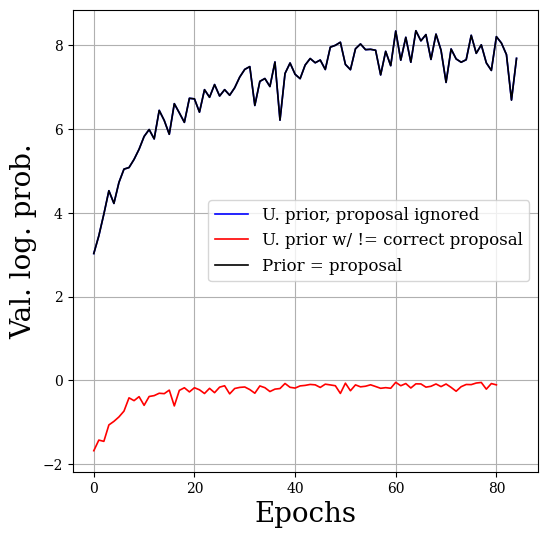

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(val_priU, linewidth=1.2, color = "blue", label = "U. prior, proposal ignored")
plt.plot(val_priUproU, linewidth=1.2, color = "red", label = "U. prior w/ != correct proposal")
plt.plot(val_proU, linewidth=1.2, color = "black", label = "Prior = proposal")
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 12, loc = "best")
plt.grid()

### Test the TARP metric for trained posteriors, first example

Text(0.5, 0, 'Credibility Level')

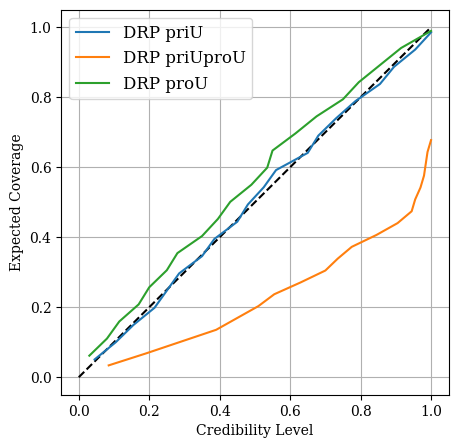

In [ ]:
# plot the TARP metric
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], ls='--', color='k')
ax.plot(alpha_priU, ecp_priU, label='DRP priU')
ax.plot(alpha_priUproU, ecp_priUproU, label='DRP priUproU')
ax.plot(alpha_proU, ecp_proU, label='DRP proU')
ax.legend(loc= "upper left", fontsize = 12)
ax.grid()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

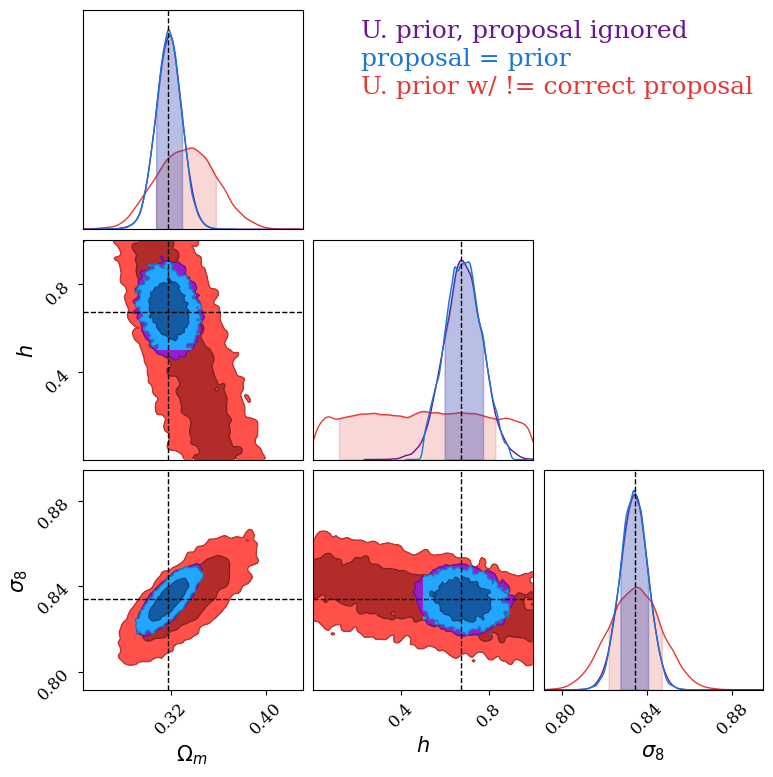

In [ ]:
# Let's pretend the observed data is the mean of my theoretical predictions
posterior_proU_samples = posterior_proU.sample((10000,), x = pk0)
posterior_priU_samples = posterior_priU.sample((10000,), x = pk0)
posterior_priUproU_samples = posterior_priUproU.sample((10000,), x = pk0)

cornerPlotSize = 8
ct = ChainConsumer()

ct.add_chain(posterior_priU_samples.cpu().numpy(), parameters = chosenStr, name = "U. prior, proposal ignored", zorder = 1, color="#6A1592")
ct.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "proposal = prior", zorder = 2, color="blue")
ct.add_chain(posterior_priUproU_samples.cpu().numpy(), parameters = chosenStr, name = "U. prior w/ != correct proposal", zorder = 0, color = "red")
ct.configure(serif = True, shade=[True, True, True], shade_alpha=1.0, bar_shade=True,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 18},
            legend_color_text=True)
fig = ct.plotter.plot(figsize  =(cornerPlotSize,cornerPlotSize),truth=fiducial[res])

## I-2) MAF vs MDN

In [ ]:
# Density Estimator MAF specs: A bit more customization than the high level interface of sbi
# Here we specify a neural network targeting the posterior for SNPE
typeDE = "maf" # Masked Autoregressive Flows
nHiddenMAF = 80 # default is 50
numT = 5 # number of stacked MADEs in the MAF, default is 5 if not specified
dropoutMAF = 0.2 # the high-level sbi interface set this to 0.0 by default
batchNorm = True # use_batch_norm = False by default in high-level sbi
activationType = torch.tanh # default of high-level sbi is torch.tanh for buld_maf

# For more details with eg MAF, check the function build_maf in sbi/sbi/neural_nets/flow.py
densityEstMAF = utils.get_nn_models.posterior_nn(model = typeDE, hidden_features = nHiddenMAF, num_transforms = numT,
                                           activation = activationType, dropout_probability = dropoutMAF, use_batch_norm = batchNorm)

In [ ]:
# MAF posterior training
posterior_MAF, val_MAF, alpha_MAF, ecp_MAF = run_SNPE_C(densityEstMAF, proposalU, pkTorch, thetaTorch, pkTorch_test, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

 Neural network successfully converged after 99 epochs.

100%|██████████| 200/200 [00:05<00:00, 35.24it/s]


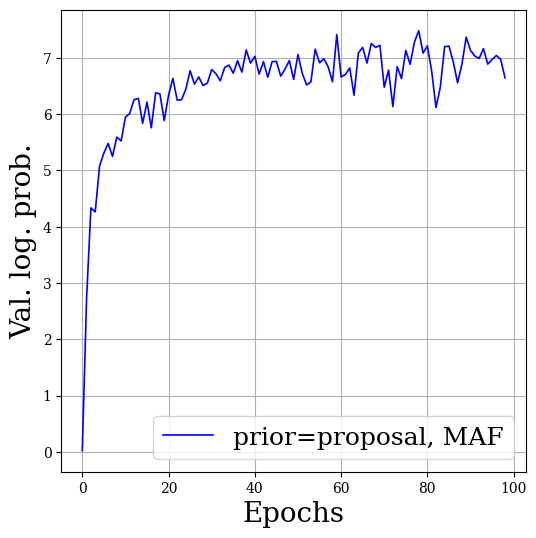

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(val_MAF, linewidth=1.2, color = "blue", label = "prior=proposal, MAF")
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

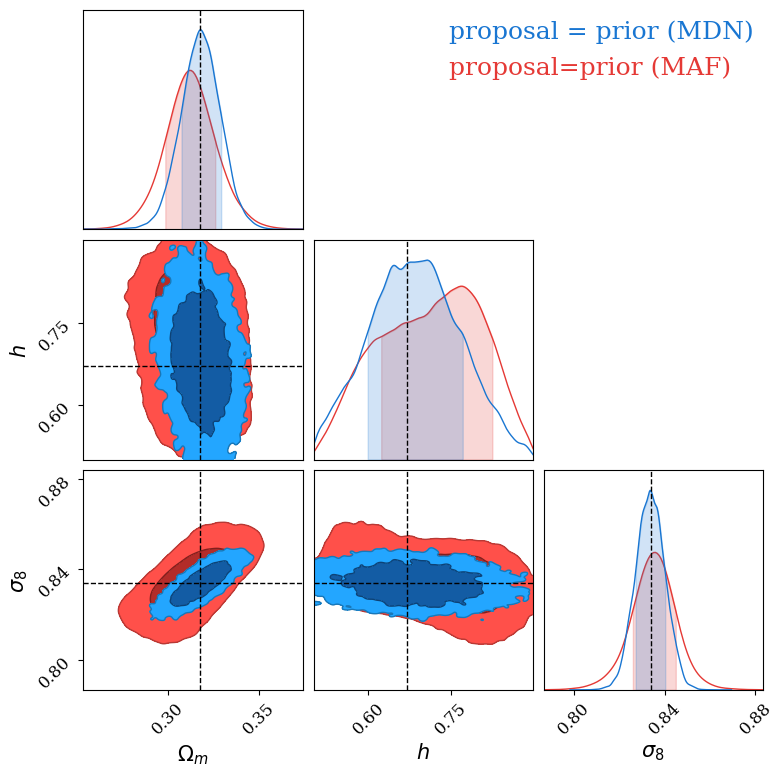

In [ ]:
# Priors would be added at the build_posterior stage for SNLE, here we use SNPE
posterior_proU_maf_samples = posterior_MAF.sample((100000,), x = pk0)

cornerPlotSize = 8
ct = ChainConsumer()

ct.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "proposal = prior (MDN)", zorder = 2, color="blue")
ct.add_chain(posterior_proU_maf_samples.cpu().numpy(), parameters = chosenStr, name = "proposal=prior (MAF)", zorder = 0, color = "red")
ct.configure(serif = True, shade=[True, True], shade_alpha=1.0, bar_shade=True,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 18},
            legend_color_text=True)
fig = ct.plotter.plot(figsize  =(cornerPlotSize,cornerPlotSize),truth=fiducial[res])

Text(0.5, 0, 'Credibility Level')

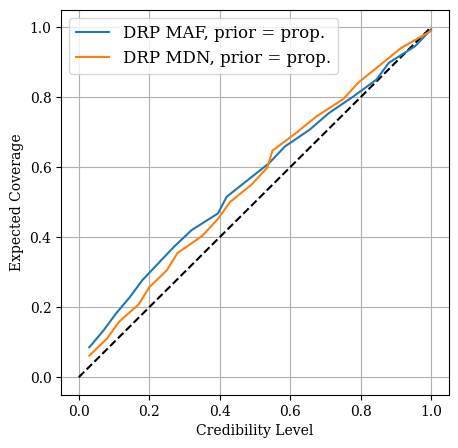

In [ ]:
# plot the TARP metric
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], ls='--', color='k')
ax.plot(alpha_MAF, ecp_MAF, label='DRP MAF, prior = prop.')
ax.plot(alpha_proU, ecp_proU, label='DRP MDN, prior = prop.')
ax.legend(loc= "upper left", fontsize = 12)
ax.grid()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")

## I-3) True proposal versus MVN Planck (proposal ignored)

 Neural network successfully converged after 85 epochs.

100%|██████████| 200/200 [00:00<00:00, 388.40it/s]


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

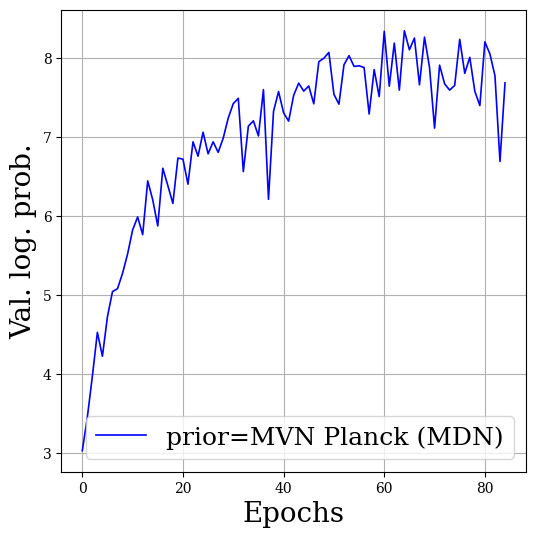

In [ ]:
posterior_priMVN, val_priMVN, alpha_priMVN, ecp_priMVN = run_SNPE_C(densityEstMDN, priorMVN, pkTorch, thetaTorch, pkTorch_test, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)
posterior_priMVN_samples = posterior_priMVN.sample((10000,), x = pk0)

plt.figure(figsize=(6,6))
plt.plot(val_priMVN, linewidth=1.2, color = "blue", label = "prior=MVN Planck (MDN)")
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

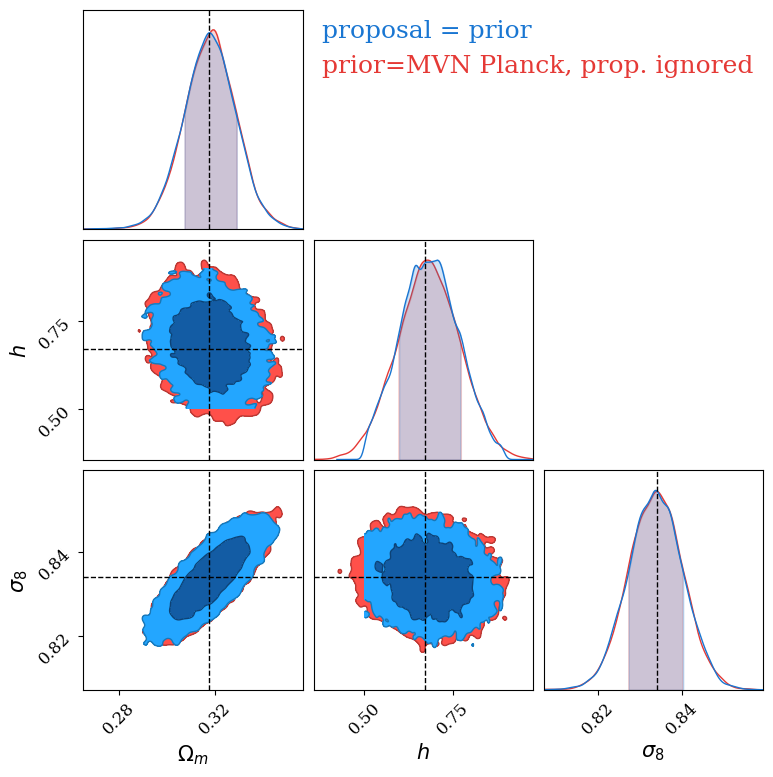

In [ ]:
cornerPlotSize = 8
ct = ChainConsumer()

ct.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "proposal = prior", zorder = 2, color="blue")
ct.add_chain(posterior_priMVN_samples.cpu().numpy(), parameters = chosenStr, name = "prior=MVN Planck, prop. ignored", zorder = 0, color = "red")
ct.configure(serif = True, shade=[True, True], shade_alpha=1.0, bar_shade=True,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 18},
            legend_color_text=True)
fig = ct.plotter.plot(figsize  =(cornerPlotSize,cornerPlotSize),truth=fiducial[res])

Text(0.5, 0, 'Credibility Level')

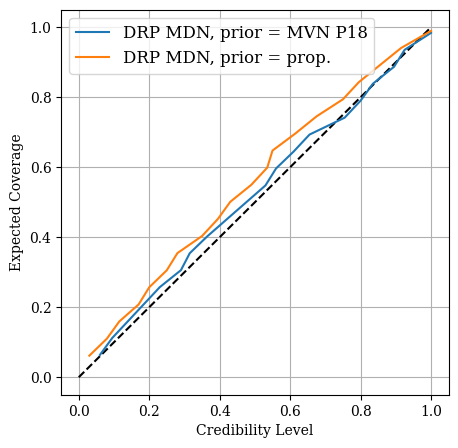

In [ ]:
# plot the TARP metric
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], ls='--', color='k')
ax.plot(alpha_priMVN, ecp_priMVN, label='DRP MDN, prior = MVN P18')
ax.plot(alpha_proU, ecp_proU, label='DRP MDN, prior = prop.')
ax.legend(loc= "upper left", fontsize = 12)
ax.grid()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")

## I-4) SNLE vs SNPE example (needs fixing/investigating)
This notebook focuses on SNPE. Here is one example of SNPE_A, SNLE_C currently having issues in sbi (see last cell of this subsection)
NB: actually same "bug" with SNLE_A.
#### We need to investigate as with the same data tensors to call SNPE or SNLE instances, the latter type fails in current version.

In [ ]:
posterior_lkl, val_lkl, alpha_lkl, ecp_prilkl = run_SNLE_A(densityEstMDN, proposalU, pkTorch, thetaTorch, pkTorch_test, thetaTorch_test, pk0,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

RuntimeError: ignored

In [ ]:
# Basic setting of an SNLE instance, with the MDN defined earlier
torch.manual_seed(9)
inference_LKL = SNLE_A(density_estimator = densityEstMDN, show_progress_bars = True, device = deviceStr)
print(thetaTorch.shape)
print(pkTorch.shape)
LKL = inference_LKL.append_simulations(theta = thetaTorch, x = pkTorch)
LKL = LKL.train()

torch.Size([1800, 3])
torch.Size([1800, 158])


RuntimeError: ignored

# II) Power sectrum and non-informative noise

**We only use the proposal prior from the Quijote simulations as of now, diretly passed as the prior to inference instances**
We are also going to see if shuffling the elements of the "data+noise" vector completely impedes the inference capabilities

**In summary, we look at aspects:**
- Dimension of the noise relatively to the "informative" summary vector
- Whether shuffling uninformative and informative elements beforehand has an impact on inference

In [ ]:
# Generate random multivariate noise to concatenate to the Power spectrum data
np.random.seed(42)

# Ratio designates the dimesion of the added noise wrt that of the actual mock data vector that carries info about parameters
#   S for small, M for medium...
ratioNoise_M = 1.0
ratioNoise_S = 0.2
dimNoise_M = int(np.floor(ratioNoise_M*len(k3D)))
dimNoise_S = int(np.floor(ratioNoise_S*len(k3D)))
noiseArr_M = np.zeros((2000,dimNoise_M), dtype = float)
noiseArr_S = np.zeros((2000,dimNoise_S), dtype = float)

for n in range(len(seedsLH[:])):
  noiseArr_M[n,:] = np.random.multivariate_normal(1e2 * np.pi*np.ones((dimNoise_M,)),1e3 * np.e* np.pi/2.0 * np.eye(dimNoise_M))
  noiseArr_S[n,:] = np.random.multivariate_normal(1e2 * np.pi*np.ones((dimNoise_S,)), 1e3 * np.e * np.pi/2.0 * np.eye(dimNoise_S))

# First vector: Pk + noise, concatenated
pkPlusNoise_M = np.concatenate((pkLH_ell, noiseArr_M), axis = 1)
pkPlusNoise_S = np.concatenate((pkLH_ell, noiseArr_S), axis = 1)

# Second vector: Pk + noise, concatenated and shuffled
# CAREFUL: np.random.shuffle shuffles arrays along the first axis only
seedShuffle = 9
pkPlusNoise_shM = np.concatenate((pkLH_ell, noiseArr_M), axis = 1).T
pkPlusNoise_shS = np.concatenate((pkLH_ell, noiseArr_S), axis = 1).T
print(pkPlusNoise_shM.shape)

np.random.seed(seedShuffle)
np.random.shuffle(pkPlusNoise_shM)
pkPlusNoise_shM = pkPlusNoise_shM.T
print(pkPlusNoise_shM.shape)

np.random.seed(seedShuffle)
np.random.shuffle(pkPlusNoise_shS)
pkPlusNoise_shS = pkPlusNoise_shS.T

(316, 2000)
(2000, 316)


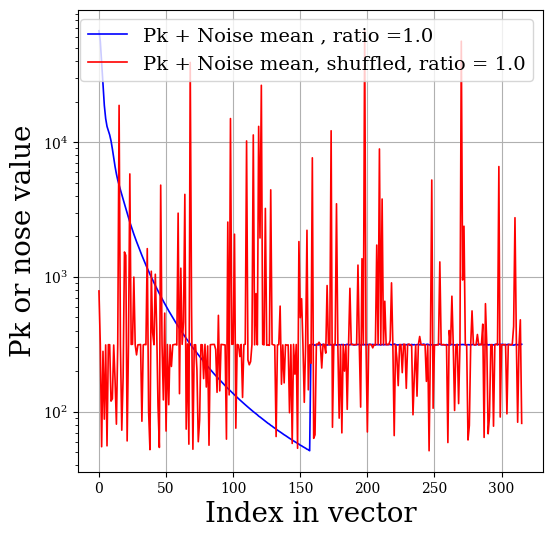

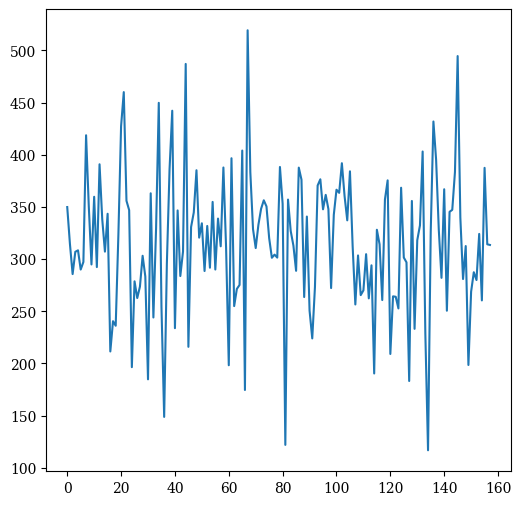

In [ ]:
# Plot Pk monopole example and the fiducial mean for illustration

plt.figure(figsize=(6,6))
plt.semilogy(np.mean(pkPlusNoise_M, axis = 0), linewidth=1.2, color = "blue", label = "Pk + Noise mean , ratio =%1.1f"%ratioNoise_M)
plt.semilogy(np.mean(pkPlusNoise_shM,axis = 0), linewidth=1.2, color = "red", label = "Pk + Noise mean, shuffled, ratio = %1.1f"%ratioNoise_M)
plt.xlabel("Index in vector",fontsize=20)
plt.ylabel("Pk or nose value",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 14, loc = "best")
plt.grid()

plt.figure(figsize=(6,6))
plt.plot(noiseArr_M[10,:])

## II-0) Setup for the tests

In [ ]:
# Redo the analysis with pkPlus noise
# pkLH_ell[:n_train,:]
pkPlusNoiseTorch_M = torch.from_numpy(pkPlusNoise_M[:n_train,:]).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_S = torch.from_numpy(pkPlusNoise_S[:n_train,:]).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_shM = torch.from_numpy(pkPlusNoise_shM[:n_train,:]).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_shS = torch.from_numpy(pkPlusNoise_shS[:n_train,:]).to(dtype= torch.float32, device  = device)

pkPlusNoiseTorch_MTest = torch.from_numpy(pkPlusNoise_M[n_train:,:]).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_STest = torch.from_numpy(pkPlusNoise_S[n_train:,:]).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_shMTest = torch.from_numpy(pkPlusNoise_shM[n_train:,:]).to(dtype= torch.float32, device  = device)
pkPlusNoiseTorch_shSTest = torch.from_numpy(pkPlusNoise_shS[n_train:,:]).to(dtype= torch.float32, device  = device)

In [ ]:
# Possibility to change the density estimator for Pk + noise
nHiddenNoise = 100 # default is 50
numNoise= 10 # number of components for MDN
dropoutNoise= 0.2

# Training hyperparameters
myBatchSize = 64
myLearningRate = 1e-3
myValFraction = 0.1

# Seeds and number of TARP samples
nTARP = 10000
mySeed = 2023

densityEstNoise = utils.get_nn_models.posterior_nn(model = "mdn", hidden_features = nHiddenNoise, num_components = numNoise, dropout_probability = dropoutNoise)

## II-1) Same MDN for concatenated Pk + noise with different noise dimensions

In [ ]:
posterior_pknS, val_pknS, alpha_pknS, ecp_pknS = run_SNPE_C(densityEstNoise, proposalU, pkPlusNoiseTorch_S,
                                                            thetaTorch, pkPlusNoiseTorch_STest, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

/usr/local/lib/python3.10/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 70 epochs.

100%|██████████| 200/200 [00:00<00:00, 234.47it/s]


In [ ]:
posterior_pknM, val_pknM, alpha_pknM, ecp_pknM = run_SNPE_C(densityEstNoise, proposalU, pkPlusNoiseTorch_M,
                                                            thetaTorch, pkPlusNoiseTorch_MTest, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

 Neural network successfully converged after 38 epochs.

100%|██████████| 200/200 [00:01<00:00, 199.26it/s]


## II-2) Same MDN for shuffled Pk + noise, with different noise dimensions

In [ ]:
posterior_pknshS, val_pknshS, alpha_pknshS, ecp_pknshS = run_SNPE_C(densityEstNoise, proposalU, pkPlusNoiseTorch_shS,
                                                            thetaTorch, pkPlusNoiseTorch_shSTest, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

 Neural network successfully converged after 70 epochs.

100%|██████████| 200/200 [00:00<00:00, 237.60it/s]


In [ ]:
posterior_pknshM, val_pknshM, alpha_pknshM, ecp_pknshM = run_SNPE_C(densityEstNoise, proposalU, pkPlusNoiseTorch_shM,
                                                            thetaTorch, pkPlusNoiseTorch_shMTest, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

 Neural network successfully converged after 35 epochs.

 46%|████▌     | 92/200 [00:00<00:00, 209.54it/s]WARNING:root:Only 0.000% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    10000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 94%|█████████▍| 188/200 [01:07<00:02,  4.19it/s]WARNING:root:Only 0.100% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    9990 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
100%|██████████| 200/200 [01:11<00:00,  2.81it/s]


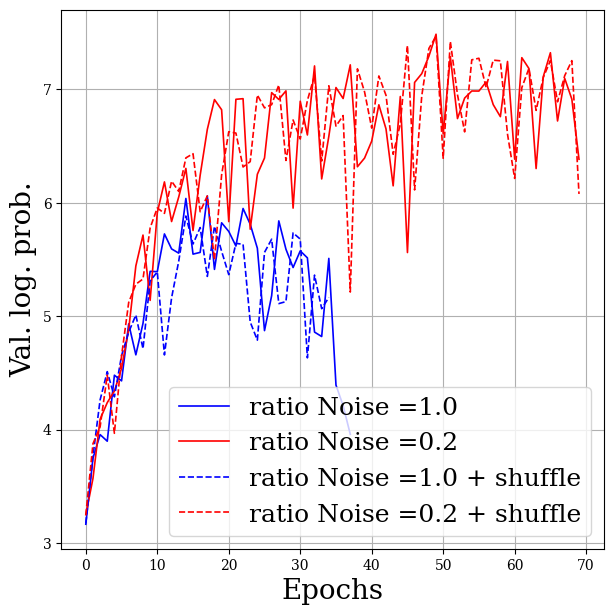

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(val_pknM, linewidth=1.2, color = "blue", label = "ratio Noise =%1.1f"%ratioNoise_M)
plt.plot(val_pknS, linewidth=1.2, color = "red", label = "ratio Noise =%1.1f"%ratioNoise_S)
plt.plot(val_pknshM, linewidth=1.2, color = "blue",linestyle = "dashed", label = "ratio Noise =%1.1f + shuffle"%ratioNoise_M)
plt.plot(val_pknshS, linewidth=1.2, color = "red",linestyle = "dashed", label = "ratio Noise =%1.1f + shuffle"%ratioNoise_S)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [ ]:
# Shuffled observation for shuffled case
# Let's pretend the observed data is the mean of my theoretical predictions
np.random.seed(890)
noise0_S = np.random.multivariate_normal(np.pi*np.ones((dimNoise_S,)),np.pi/2.0 * np.eye(dimNoise_S))
noise0_M = np.random.multivariate_normal(np.pi*np.ones((dimNoise_M,)),np.pi/2.0 * np.eye(dimNoise_M))
pk0Noise_S = torch.from_numpy(np.concatenate((pk0.cpu().numpy(),noise0_S))).to(dtype = torch.float32, device = device)
pk0Noise_M = torch.from_numpy(np.concatenate((pk0.cpu().numpy(),noise0_M))).to(dtype = torch.float32, device = device)

# Shuffled observation,careful!
pk0Noise_shS = copy.copy(pk0Noise_S.cpu().numpy())
np.random.seed(seedShuffle)
np.random.shuffle(pk0Noise_shS)

pk0Noise_shM = copy.copy(pk0Noise_M.cpu().numpy())
np.random.seed(seedShuffle)
np.random.shuffle(pk0Noise_shM)

In [ ]:
posteriorNoiseS_samples = posterior_pknS.sample((10000,), x=pk0Noise_S)
posteriorNoiseM_samples = posterior_pknM.sample((10000,), x=pk0Noise_M)
posteriorNoise_shS_samples = posterior_pknshS.sample((10000,), x=torch.from_numpy(pk0Noise_shS).to(dtype = torch.float32, device = device))
posteriorNoise_shM_samples = posterior_pknshM.sample((10000,), x=torch.from_numpy(pk0Noise_shM).to(dtype = torch.float32, device = device))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

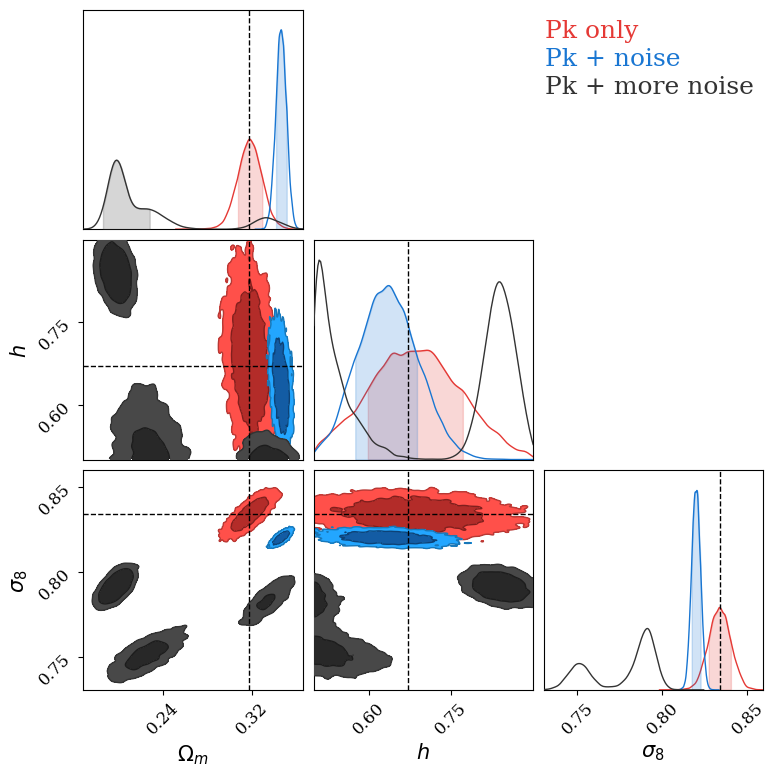

In [ ]:
c2 = ChainConsumer()

c2.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "Pk only", zorder = 1, color = "red")
c2.add_chain(posteriorNoiseS_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise", zorder = 2, color = "blue")
c2.add_chain(posteriorNoiseM_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + more noise", zorder = 3, color = "k")
c2.configure(serif = True, shade=True, shade_alpha=1.0, bar_shade=True,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 18},
            legend_color_text=True)
figNew = c2.plotter.plot(figsize  =(cornerPlotSize , cornerPlotSize),truth=fiducial[res])

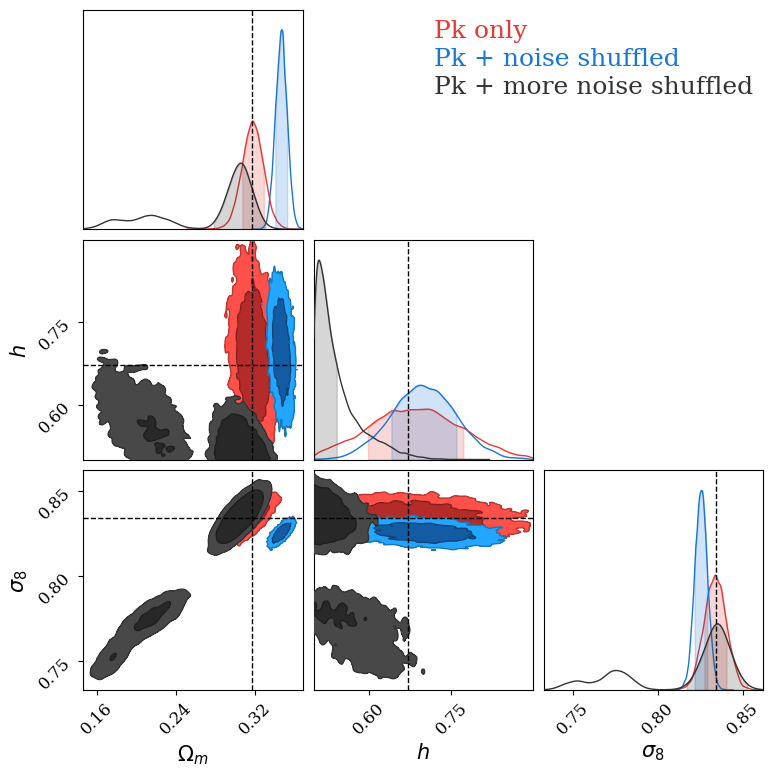

In [ ]:
c3 = ChainConsumer()

c3.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "Pk only", zorder = 1, color = "red")
c3.add_chain(posteriorNoise_shS_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise shuffled", zorder = 2, color = "blue")
c3.add_chain(posteriorNoise_shM_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + more noise shuffled", zorder = 3, color = "k")
c3.configure(serif = True, shade=True, shade_alpha=1.0, bar_shade=True,
            diagonal_tick_labels=True, tick_font_size=12, label_font_size=15, max_ticks=3,
            legend_kwargs={"loc": "upper right", "fontsize": 18},
            legend_color_text=True)
figNew = c3.plotter.plot(figsize  =(cornerPlotSize , cornerPlotSize),truth=fiducial[res])

### Remarks
 - We do not see significative differences whether we shuffle the noise vector elemts or not withing the informative summary.
 - **Question**: With the autoregressive nature of MAFs (which are constituted of MADEs), should we expect that the order of elements in the data vector has an impact, especially in our case where uninformative noise is present in the data vector? This question could be dealt with in further examples.

Text(0.5, 0, 'Credibility Level')

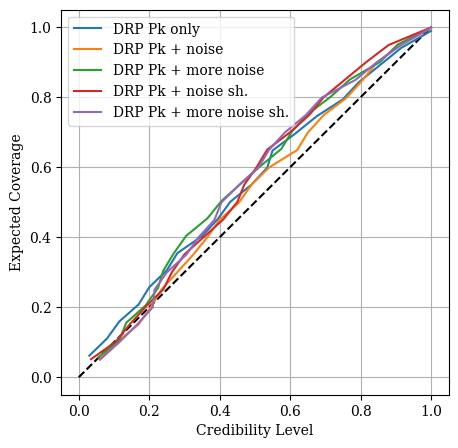

In [ ]:
# plot the TARP metric
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], ls='--', color='k')
ax.plot(alpha_proU, ecp_proU, label='DRP Pk only')
ax.plot(alpha_pknS, ecp_pknS, label='DRP Pk + noise')
ax.plot(alpha_pknM, ecp_pknM, label='DRP Pk + more noise')
ax.plot(alpha_pknshS, ecp_pknshS, label='DRP Pk + noise sh.')
ax.plot(alpha_pknshM, ecp_pknshM, label='DRP Pk + more noise sh.')
ax.legend(loc= "upper left", fontsize = 10)
ax.grid()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")

## II-3) Braindead solution = bigger network
Let's just see if using bigger MDNs works better for the Pk + noise (concatenated) case, for different noise sizes

In [ ]:
# Let's see if having begger networks improve the M cases
nHiddenNoiseBig = 200 # default is 50
numNoiseBig= 12
dropoutBig = 0.2

densityEstNoiseBig = densityEstMDN = utils.get_nn_models.posterior_nn(model = "mdn", hidden_features = nHiddenNoiseBig, num_components = numNoiseBig,
                                                                      dropout_probability = dropoutBig)

In [ ]:
posterior_pknSBig, val_pknSBig, alpha_pknSBig, ecp_pknSBig = run_SNPE_C(densityEstNoiseBig, proposalU, pkPlusNoiseTorch_S,
                                                            thetaTorch, pkPlusNoiseTorch_STest, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

posterior_pknMBig, val_pknMBig, alpha_pknMBig, ecp_pknMBig = run_SNPE_C(densityEstNoiseBig, proposalU, pkPlusNoiseTorch_M,
                                                            thetaTorch, pkPlusNoiseTorch_MTest, thetaTorch_test,
            myBatchSize, myLearningRate, myValFraction, nTARP, deviceStr, torchSeed = mySeed, proposal = None)

/usr/local/lib/python3.10/dist-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 64 epochs.

100%|██████████| 200/200 [00:01<00:00, 164.94it/s]


 Neural network successfully converged after 32 epochs.

 44%|████▍     | 88/200 [00:00<00:00, 182.45it/s]WARNING:root:Only 0.130% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    9987 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
100%|██████████| 200/200 [00:01<00:00, 103.48it/s]


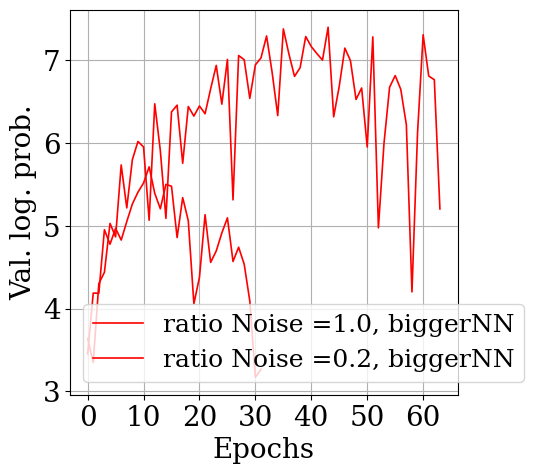

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(val_pknMBig, linewidth=1.2, color = "red", label = "ratio Noise =%1.1f, biggerNN"%ratioNoise_M)
plt.plot(val_pknSBig, linewidth=1.2, color = "red", label = "ratio Noise =%1.1f, biggerNN"%ratioNoise_S)
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize=20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [ ]:
posteriorNoise_MBig_samples = posterior_pknMBig.sample((100000,), x=pk0Noise_M)
posteriorNoise_SBig_samples = posterior_pknSBig.sample((100000,), x= pk0Noise_S)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

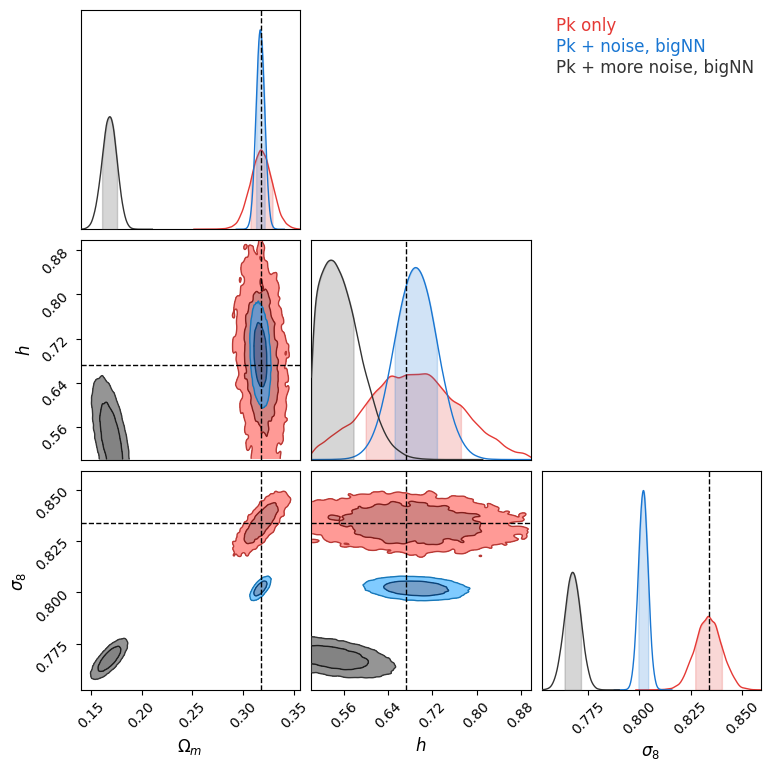

In [ ]:
c4 = ChainConsumer()

c4.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "Pk only", zorder = 1, color = "red")
c4.add_chain(posteriorNoise_SBig_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + noise, bigNN", zorder = 2, color = "blue")
c4.add_chain(posteriorNoise_MBig_samples.cpu().numpy(), parameters = chosenStr, name = "Pk + more noise, bigNN", zorder = 3, color = "k")
figNew = c4.plotter.plot(figsize  =(cornerPlotSize , cornerPlotSize),truth=fiducial[res])

Text(0.5, 0, 'Credibility Level')

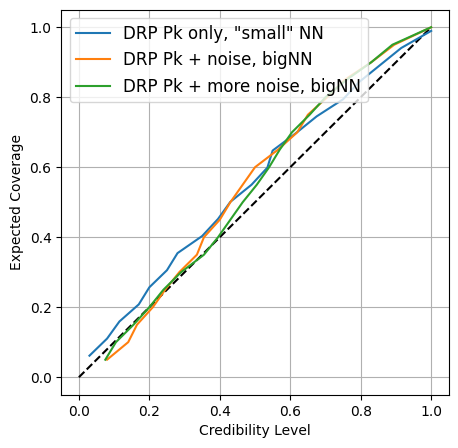

In [ ]:
# plot the TARP metric
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], ls='--', color='k')
ax.plot(alpha_proU, ecp_proU, label='DRP Pk only, "small" NN ')
ax.plot(alpha_pknSBig, ecp_pknSBig, label='DRP Pk + noise, bigNN')
ax.plot(alpha_pknMBig, ecp_pknMBig, label='DRP Pk + more noise, bigNN')
ax.legend(loc= "upper left", fontsize = 12)
ax.grid()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")

# III) (OLD) Constraints with Bispectrum and  Power Spectrum
For bispectrum and poser spectrum + bispectrum, there will be another notebook

In [ ]:
fileBkIso_LH = "LH_Bk_RSD%i_iso.h5"%axRSD
fileBkIso_Fid = "Fid_Bk_RSD%i_iso.h5"%axRSD
bkIso_Fid = pd.read_hdf(dataDir + "/Bk/" + fileBkIso_Fid)
colBkIso = bkIso_Fid.columns.to_list()
print(colBkIso)
#isoMean = bkIso_Fid.groupby(["k3Overk1"])["q123"].mean()
#bkIso0 = torch.from_numpy(np.mean(pkFid_ell, axis = 0)).to(dtype = torch.float32, device = deviceStr)

In [ ]:
# Load some fiducial data for fake observation x_0
fileBkIso_Fid = "Fid_Bk_RSD%i_raw.h5"%axRSD
#print(bkIso.columns.to_list())
bkIso_Fid = pd.read_hdf(dataDir + "/Bk/"+fileBkIso_Fid, mode = "r")
bkIso_Fid["k2Overk1"] = bkIso_Fid["j_k"]/bkIso_Fid["i_k"]
bkIso_Fid["k3Overk1"] = bkIso_Fid["l_k"]/bkIso_Fid["i_k"]

# For isosceles triangles
bkIso_Fid.drop(columns = ["i_k", "j_k", "l_k"], inplace = True)

dataIso_Fid = bkIso_Fid[bkIso_Fid.k2Overk1 == 1.0]
dataIso_Fid.drop(columns = ["k2Overk1"], inplace = True)
dataIso_Fid = dataIso_Fid.groupby(["Seed", "k3Overk1"]).apply(lambda d: (np.average(d["b123"],
                              weights = d["counts"]),np.average(d["q123"],
                             weights = d["counts"]), d["counts"].sum()))


dataIso_Fid = dataIso_Fid.to_frame(name = "temp")

# At ths point dataTemp.columns returns Index(['temp'], dtype='object'): need for workaround
dataIso_Fid[["b123","q123","counts"]] = pd.DataFrame(dataIso_Fid["temp"].to_list(), index = dataIso_Fid.index)
dataIso_Fid.drop(columns=["temp"], inplace=True)
dataIso_Fid.reset_index(level = dataIso_Fid.index.names, inplace=True)

<ipython-input-82-08fd4ac6e9f0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataIso_Fid.drop(columns = ["k2Overk1"], inplace = True)


(648,)


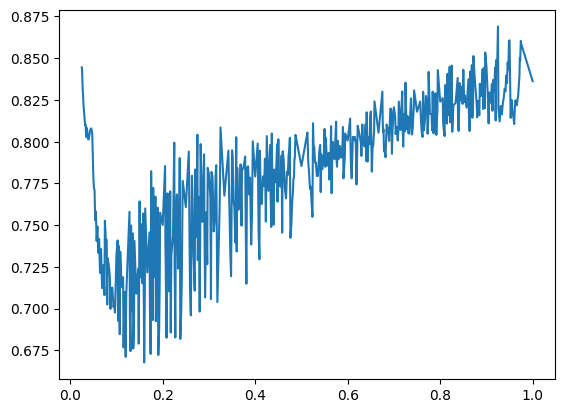

In [ ]:
# Mean of fake observation
meanIsoFid = dataIso_Fid.groupby("k3Overk1")["q123"].mean().to_numpy()
pkbkFid = np.concatenate((pk0.cpu().numpy(), meanIsoFid))
print(pkbkFid.shape)
pkbkFidT = torch.from_numpy(pkbkFid).to(dtype = torch.float32, device = device)
plt.figure()
plt.plot(dataIso_Fid[dataIso_Fid.Seed==0].k3Overk1.to_numpy(),meanIsoFid)
meanIsoFidT = torch.from_numpy(meanIsoFid).to(dtype = torch.float32, device = device)

In [ ]:
# Load some fiducial data for fake observation x_0
fileBkIso_LH = "LH_Bk_RSD%i_raw.h5"%axRSD
bkIso_LH = pd.read_hdf(dataDir + "/Bk/"+fileBkIso_LH, mode = "r")
bkIso_LH["k2Overk1"] = bkIso_LH["j_k"]/bkIso_LH["i_k"]
bkIso_LH["k3Overk1"] = bkIso_LH["l_k"]/bkIso_LH["i_k"]

# Foror isosceles triangles
colLabels = ["Seed","k2Overk1", "k3Overk1" ,"b123", "q123", "counts"]
bkIso_LH.drop(columns = ["i_k", "j_k", "l_k"], inplace = True)

dataIso_LH = bkIso_LH[bkIso_LH.k2Overk1 == 1.0]
dataIso_LH.drop(columns = ["k2Overk1"], inplace = True)
dataIso_LH = dataIso_LH.groupby(["Seed", "k3Overk1"]).apply(lambda d: (np.average(d["b123"],
                              weights = d["counts"]),np.average(d["q123"],
                             weights = d["counts"]), d["counts"].sum()))


dataIso_LH = dataIso_LH.to_frame(name = "temp")

# At ths point dataTemp.columns returns Index(['temp'], dtype='object'): need for workaround
dataIso_LH[["b123","q123","counts"]] = pd.DataFrame(dataIso_LH["temp"].to_list(), index = dataIso_LH.index)
dataIso_LH.drop(columns=["temp"], inplace=True)
dataIso_LH.reset_index(level = dataIso_LH.index.names, inplace=True)

<ipython-input-84-5192df3f659d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataIso_LH.drop(columns = ["k2Overk1"], inplace = True)


In [ ]:
NseedsBk = len(dataIso_LH.Seed.unique())
pB = len(dataIso_LH[dataIso_LH.Seed == dataIso_LH.Seed.unique()[0]].index)

bkLH_Arr = np.zeros((NseedsBk,pB), dtype = np.float32)

for n in range(NseedsBk):
  bkLH_Arr[n,:] = dataIso_LH[dataIso_LH.Seed == n].q123.to_numpy()

bkTorch = torch.from_numpy(bkLH_Arr).to(dtype = torch.float32, device = device)
print(bkTorch.shape)

torch.Size([2000, 490])


In [ ]:
pkPlusBk = np.concatenate((pkLH_ell, bkLH_Arr), axis = 1)
pkBkTorch = torch.from_numpy(pkPlusBk).to(dtype = torch.float32, device = device)
print(pkBkTorch.shape)

torch.Size([2000, 648])


In [ ]:
# Here we specify a neural network for the MDN case
nHiddenBk = 120 # default is 50
numCompBk = 6 # number of mixture components

# For more details on MDNs implementation, check sbi/sbi/neural_nets/mdn.py
# In mdn.py, it uses the package pyknos, and features such as the activation functions (ReLU) and dropout rate (=0.0) are fixed
densityEstBk = utils.get_nn_models.posterior_nn(model = "mdn", hidden_features = nHiddenBk, num_transforms = numCompBk)

inferencePkBk = SNPE(prior = proposalU, density_estimator = densityEstBk, show_progress_bars=True,device = deviceStr)
inferenceBk = SNPE(prior=proposalU, density_estimator = densityEstBk, show_progress_bars=True, device = deviceStr)


# Example when using pre-simulated data for training
myInferenceBk = inferenceBk.append_simulations(thetaTorch, bkTorch)


In [ ]:
#%% Parametric model for the posterior
density_estimatorBk = myInferenceBk.train()


 Neural network successfully converged after 161 epochs.

In [ ]:
print(thetaTorch.shape)
print(bkTorch.shape)
print(pkBkTorch.shape)
myInferencePkBk = inferencePkBk.append_simulations(thetaTorch, pkBkTorch)
density_estimatorPkBk = myInferencePkBk.train()

torch.Size([2000, 3])
torch.Size([2000, 490])
torch.Size([2000, 648])
 Neural network successfully converged after 146 epochs.

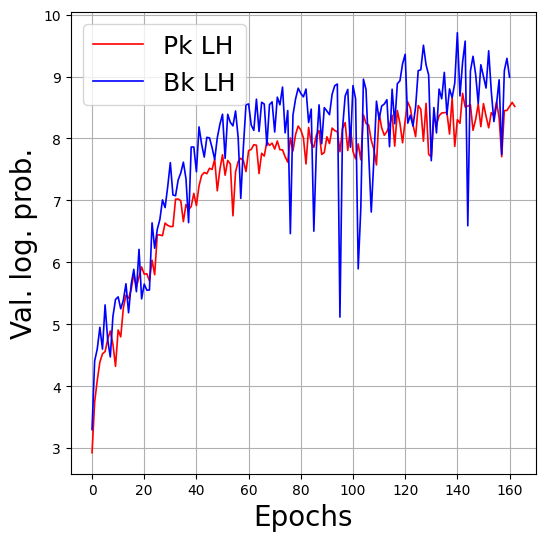

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(myInference_proU.summary["validation_log_probs"], linewidth=1.2, color = "red", label = "Pk LH")
plt.plot(myInferenceBk.summary["validation_log_probs"], linewidth=1.2, color = "blue", label = "Bk LH")
plt.xlabel("Epochs",fontsize=20)
plt.ylabel("Val. log. prob.",fontsize = 20)
#plt.ylabel(r'$P(k) [h^{-1}\rm{MPc}]^{3}$', fontsize=20)
plt.legend(fontsize = 18, loc = "best")
plt.grid()

In [ ]:
# Priors would be added at the build_posterior stage for SNLE, here we use SNPE
posteriorBk = inferenceBk.build_posterior(density_estimatorBk)
posteriorPkBk = inferencePkBk.build_posterior(density_estimatorPkBk)

In [ ]:
posteriorBk_samples = posteriorBk.sample((100000,), x=meanIsoFidT)
posteriorPkBk_samples = posteriorPkBk.sample((100000,), x=pkbkFidT)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

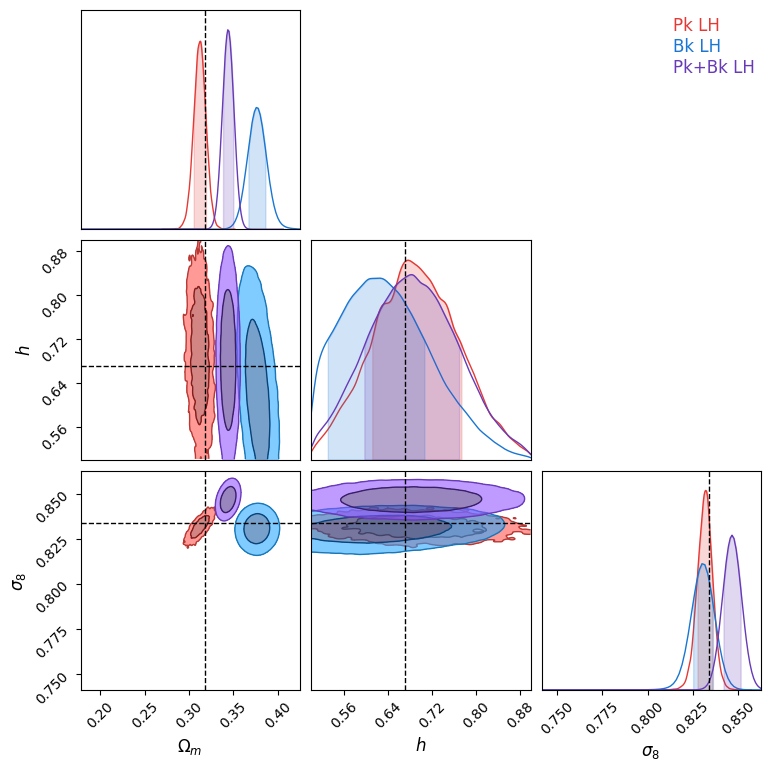

In [ ]:
c5 = ChainConsumer()

c5.add_chain(posterior_proU_samples.cpu().numpy(), parameters = chosenStr, name = "Pk LH", zorder = 1, color = "red")
c5.add_chain(posteriorBk_samples.cpu().numpy(), parameters = chosenStr, name = "Bk LH", zorder = 2, color = "blue")
c5.add_chain(posteriorPkBk_samples.cpu().numpy(), parameters = chosenStr, name = "Pk+Bk LH", zorder = 2, color = "purple")
figRe = c5.plotter.plot(figsize  =(cornerPlotSize,cornerPlotSize),truth=fiducial[res])